# Used Car Value Prediction

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# ignore warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [3]:
try:
    data = pd.read_csv('car_data.csv')
except:
    data = pd.read_csv('/datasets/car_data.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


**Features**  
`DateCrawled` — date profile was downloaded from the database  
`VehicleType` — vehicle body type  
`RegistrationYear` — vehicle registration year  
`Gearbox` — gearbox type  
`Power` — power (hp)  
`Model` — vehicle model  
`Mileage` — mileage (measured in km due to dataset's regional specifics)  
`RegistrationMonth` — vehicle registration month  
`FuelType` — fuel type  
`Brand` — vehicle brand  
`NotRepaired` — vehicle repaired or not  
`DateCreated` — date of profile creation  
`NumberOfPictures` — number of vehicle pictures  
`PostalCode` — postal code of profile owner (user)  
`LastSeen` — date of the last activity of the user  

**Target**  
`Price` — price (Euro)

As we can see there are some columns that are not relevant for assesing the vehicle's price, thus we'll remove them, such as `DateCrawled`, `DateCreated`, `NumberOfPictures` and `LastSeen`. First we'll check if there's any duplicated rows (as the timestemp will help us to determine such rows) and then we'll remove those columns.

In [5]:
data.duplicated().sum()

262

In [6]:
# remove the duplicated rows
data.drop(index = data[data.duplicated()].index, inplace = True)

In [7]:
# remove unnecessary columns for prediction 
data = data.drop(columns = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen','PostalCode'], axis = 1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354107 entries, 0 to 354368
Data columns (total 11 columns):
Price                354107 non-null int64
VehicleType          316623 non-null object
RegistrationYear     354107 non-null int64
Gearbox              334277 non-null object
Power                354107 non-null int64
Model                334406 non-null object
Mileage              354107 non-null int64
RegistrationMonth    354107 non-null int64
FuelType             321218 non-null object
Brand                354107 non-null object
NotRepaired          282962 non-null object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


In [9]:
# missing values in the data set (percentage of the data)
round(data.isna().sum().sort_values(ascending=False)*100/len(data),2)

NotRepaired          20.09
VehicleType          10.59
FuelType              9.29
Gearbox               5.60
Model                 5.56
Brand                 0.00
RegistrationMonth     0.00
Mileage               0.00
Power                 0.00
RegistrationYear      0.00
Price                 0.00
dtype: float64

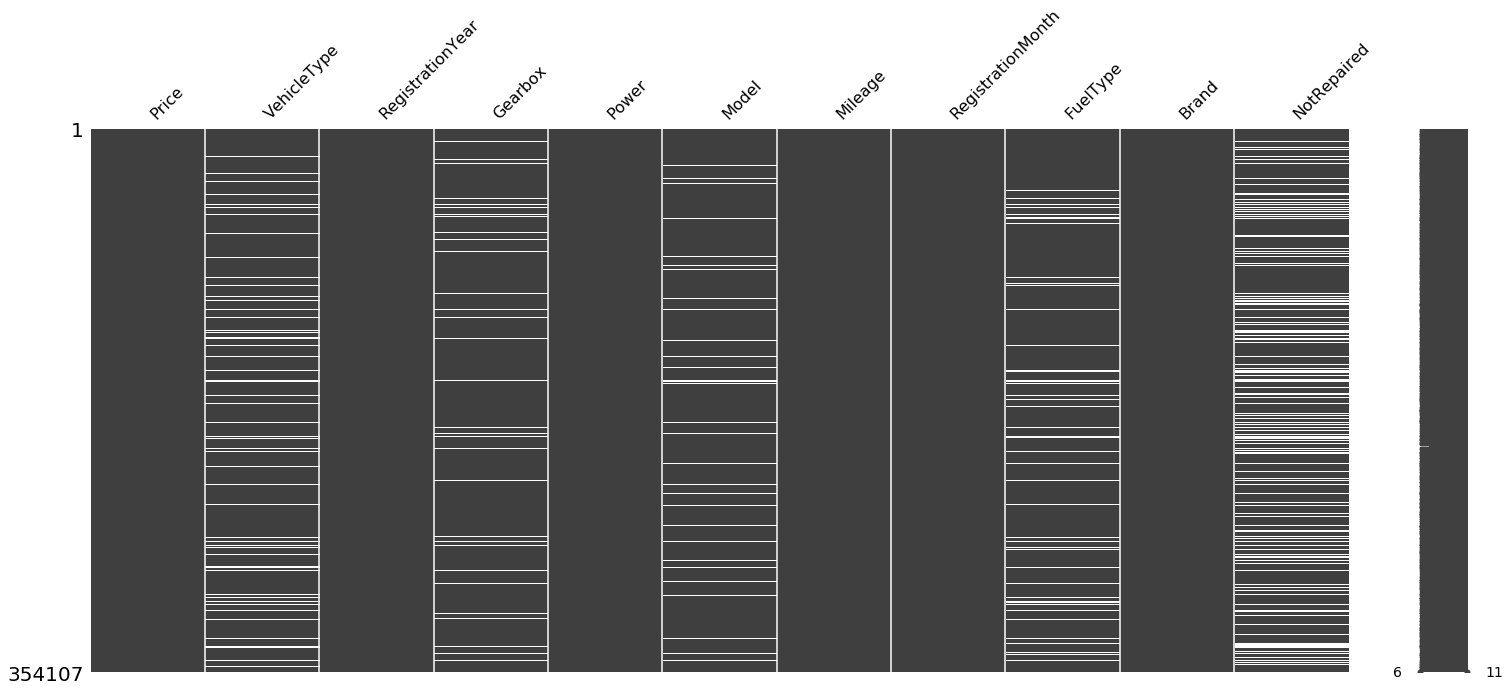

In [10]:
#visualize the missing values
msno.matrix(data);

It is not possible to predict if a vehicle is repaired or not by the data we have so although it is a huge amount of data, we'll need to drop the rows with this missing data (probably the most correlated column to this data will be the price but we want to avoid data leakage).

In [11]:
# remove rows that are missing the 'NotRepaired' values
data.drop(index = data[data['NotRepaired'].isna()].index, inplace = True)

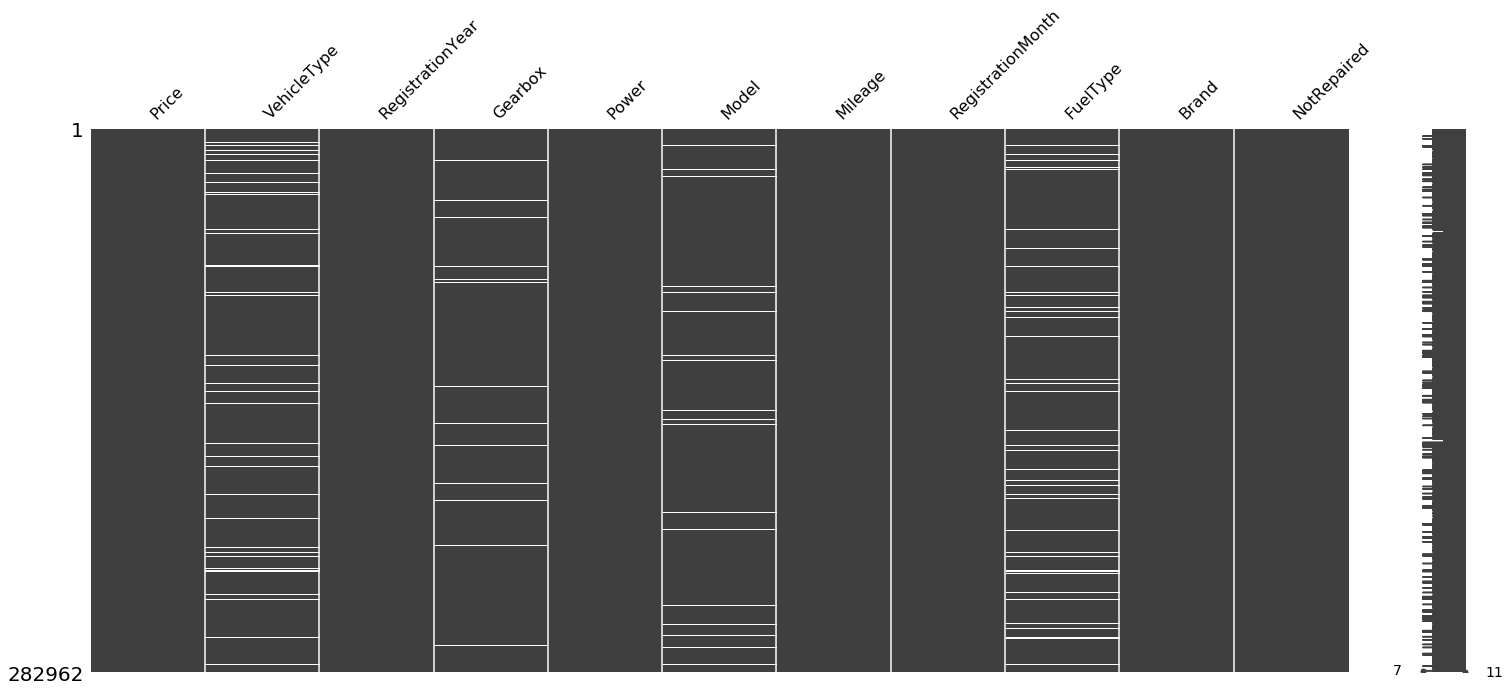

In [12]:
#visualize the missing values
msno.matrix(data);

All the missing values are of categorical type. As we have enough data we'll drop those rows with missing values. Now we want to have a look on the statistics of the features.

In [13]:
# drop the rows with missng values
data.drop(index = data[data.isna().any(axis=1)].index, inplace = True)

In [14]:
# statistics of numeric features
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,245567.000000,245567.000000,245567.000000,245567.000000,245567.000000
mean,5125.680959,2002.918287,119.971796,127297.112397,6.179401
std,4718.468928,6.164689,139.448062,37079.536493,3.479783
min,0.000000,1910.000000,0.000000,5000.000000,0.000000
25%,1499.000000,1999.000000,75.000000,125000.000000,3.000000
50%,3500.000000,2003.000000,110.000000,150000.000000,6.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,9.000000
max,20000.000000,2018.000000,20000.000000,150000.000000,12.000000


In [15]:
# statistics of categorical features
data.describe(include = [np.object])

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,245567,245567,245567,245567,245567,245567
unique,8,2,249,7,39,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,72202,194529,20184,162426,51787,217767


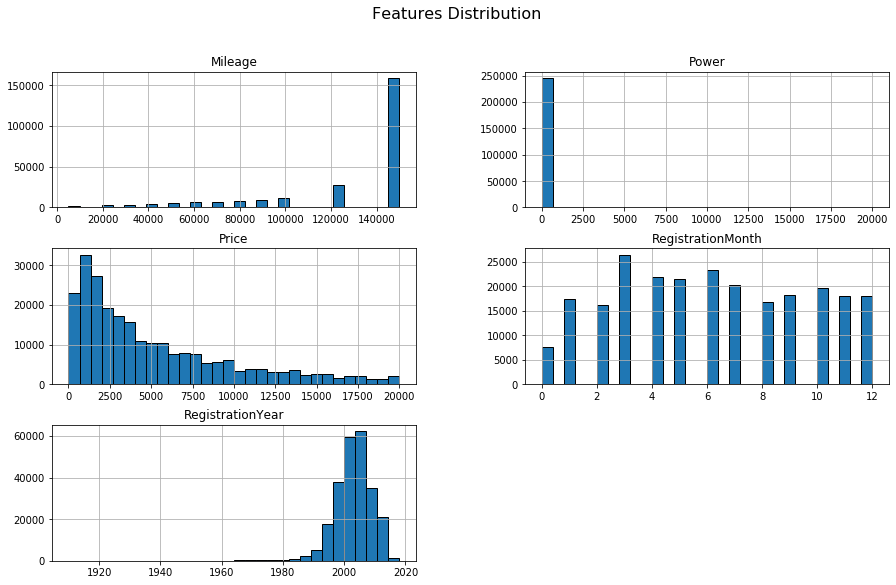

In [16]:
data.hist(edgecolor='black', figsize=(15,9), bins=30)
plt.suptitle('Features Distribution', fontsize=16);

As we can see, there are some extreme values in the `Power` column and `RegistrationYear` which might happen due to incorrect typing when posting. We'll remove those outliers. We will take 1960 as the minimal year of registration and 800 as the maximal power. Also there are some rows with `Price` of 0. We'll assume that it was intended to attract potential buyers and that's not the actual cost of the vehicle. We'll assume that 500 Euros is the minimal price.

In [17]:
# remove the outliers
data = data[(data['RegistrationYear'] > 1960) & (data['Power'] < 800) & (data['Price'] > 500)]

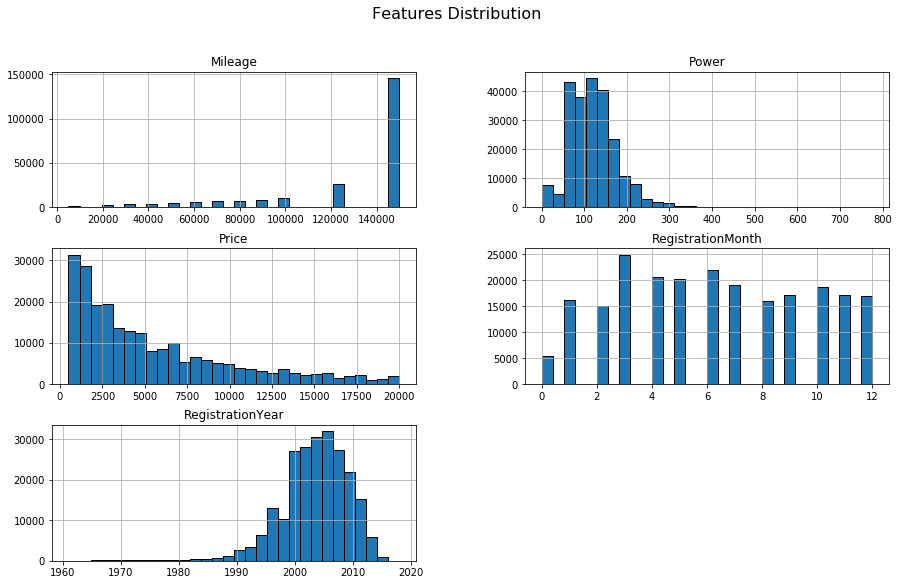

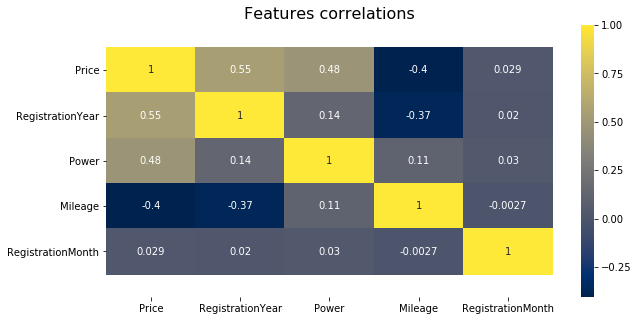

In [18]:
data.hist(edgecolor='black', figsize=(15,9), bins=30)
plt.suptitle('Features Distribution', fontsize=16)
plt.figure(figsize=(10,5))
ax = sns.heatmap(data.corr(), annot=True, cmap='cividis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);
plt.yticks(rotation=0)
plt.title('Features correlations', fontsize=16);

Now the distributions look more reasonable. We also see that there are some corrlations between the price and the features. There is a positive correlation of the Price with the Registration Year and the Power, which is pretty obvious and negative correlation with Milage as we also could guess.

In [19]:
len(data)

229204

Even though we removed a lot of data, we still have a large enough data to work with.

## Model training

Now we'll tune hyperparameters of different models and later we'll compare their training time and quality.

In [20]:
# first split each data frame to features and target
X = data.drop(['Price'], axis=1)
Y = data['Price']

In [21]:
# split the data to training set and test set
X_train, X_test, y_train, y_test = tts(X,Y,test_size=0.3, random_state=12)

We have some categorical features and there are some models thats can't deal them so we'll need to apply an encoding for those models (we'll use OneHotEncoder). Since the models that we chose do not benefit from feature scaling, we will not preprocess the numeric features.

In [22]:
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
categorical_transformer = OneHotEncoder(drop='if_binary', handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_features)],  remainder = 'passthrough'
)

### Random Forest Regressor

In [23]:
# creating a pipeline
pipe1 = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor(random_state=12))]
)

param_grid = {
    "regressor__n_estimators" : [10, 50],
    "regressor__max_depth" : [10, 20]
}

grid1 = GridSearchCV(pipe1, param_grid, cv=3, scoring = "neg_root_mean_squared_error")

grid1.fit(X_train, y_train)

print("Best params:")
print(grid1.best_params_)

print(f"Best RMSE score: {abs(grid1.best_score_):.3f}")

Best params:
{'regressor__max_depth': 20, 'regressor__n_estimators': 50}
Best RMSE score: 1621.615


###  XGB Regressor

In [24]:
# creating a pipeline
pipe2 = Pipeline(
    steps =[
        ("preprocessor", preprocessor), 
        ("regressor", XGBRegressor(objective='reg:squarederror', n_estimators = 100, random_state=12))]
)

param_grid = {
    "regressor__learning_rate" : [0.1, 0.15],
    "regressor__max_depth" : [10, 20]
         }


grid2 = GridSearchCV(pipe2, param_grid, cv=3, scoring = "neg_root_mean_squared_error")

grid2.fit(X_train, y_train)

print("Best params:")
print(grid2.best_params_)

print(f"Best RMSE score: {abs(grid2.best_score_):.3f}")

Best params:
{'regressor__learning_rate': 0.15, 'regressor__max_depth': 10}
Best RMSE score: 1559.403


### LGBM Regressor

In [25]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
for col in categorical_features:
    X_train_lgbm[col] = X_train_lgbm[col].astype('category')
    X_test_lgbm[col] = X_test_lgbm[col].astype('category')

In [26]:
# creating a LGBM Regressor
model = LGBMRegressor(random_state=12)

param_grid = {
    "learning_rate" : [0.1, 0.2],
    "n_estimators" : [150, 200],
    "max_depth" : [10, 20]
}

grid3 = GridSearchCV(model, param_grid, cv=3, scoring = "neg_root_mean_squared_error")

grid3.fit(X_train_lgbm, y_train)

print("Best params:")
print(grid3.best_params_)

print(f"Best RMSE score: {abs(grid3.best_score_):.3f}")

Best params:
{'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 200}
Best RMSE score: 1548.156


### CatBoostRegressor

In [27]:
# creating a CatBoost Regressor
model = CatBoostRegressor(
    random_state=12, max_depth = 10, cat_features = categorical_features, logging_level='Silent')

param_grid = {
    "learning_rate" : [0.25, 0.3],
    "n_estimators" : [200, 250]
}

grid4 = GridSearchCV(model, param_grid, cv=3, scoring = "neg_root_mean_squared_error")

grid4.fit(X_train, y_train)

print("Best params:")
print(grid4.best_params_)

print(f"Best RMSE score: {abs(grid4.best_score_):.3f}")

Best params:
{'learning_rate': 0.25, 'n_estimators': 250}
Best RMSE score: 1552.033


### Linear Regression for a sanity check

In [28]:
# creating a pipeline
pipe5 = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

grid5 = GridSearchCV(pipe5, param_grid = {}, cv=3, scoring = "neg_root_mean_squared_error")

grid5.fit(X_train, y_train)

print("Best params:")
print(grid5.best_params_)

print(f"Best RMSE score: {abs(grid5.best_score_):.3f}")

Best params:
{}
Best RMSE score: 2565.502


All the models have a much better RMSE score than the dummy model. Now we want to compare the preformances in terms of running time and RMSE score on the test set.

## Model analysis

In [30]:
%%time
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("regressor", RandomForestRegressor(max_depth = 20, n_estimators = 50, random_state=12))]
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f"The RMSE score: {mean_squared_error(y_test, y_pred, squared=False)}")

The RMSE score: 1579.907850680334
CPU times: user 8min 40s, sys: 0 ns, total: 8min 40s
Wall time: 9min


In [31]:
%%time
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("regressor", XGBRegressor(objective='reg:squarederror', n_estimators = 100, 
                                      learning_rate=0.15, max_depth = 10, random_state=12))]
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f"The RMSE score: {mean_squared_error(y_test, y_pred, squared=False)}")

The RMSE score: 1541.0791029903903
CPU times: user 32.8 s, sys: 0 ns, total: 32.8 s
Wall time: 33.3 s


In [32]:
%%time
model = LGBMRegressor(learning_rate = 0.2, max_depth = 20, n_estimators = 200, random_state=12)

model.fit(X_train_lgbm, y_train)
y_pred = model.predict(X_test_lgbm)
print(f"The RMSE score: {mean_squared_error(y_test, y_pred, squared=False)}")

The RMSE score: 1535.2235882002028
CPU times: user 3.95 s, sys: 0 ns, total: 3.95 s
Wall time: 3.96 s


In [33]:
%%time
model = CatBoostRegressor(learning_rate = 0.25, n_estimators = 250, max_depth = 10, 
                          cat_features=categorical_features, random_state=12, logging_level='Silent')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"The RMSE score: {mean_squared_error(y_test, y_pred, squared=False)}")

The RMSE score: 1535.2678080194542
CPU times: user 3min 24s, sys: 13.7 s, total: 3min 38s
Wall time: 3min 39s


The worset RMSE score is for Random Forest Regressor and it is 1579, the best RMSE score is for LGBM Regressor and CatBoostRegressor and it is 1535. The difference in terms of the quality are pretty small, but the runing time of the models training varies from 3.96 seconds for the LGBM Regressor to 9 min for the Random Forest Regressor.
Given these two parameters for comparison, **the most cost-effective model for our task is LGBM Regressor.**